## 0 - Import libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import json

import altair as alt
import vegafusion as vf
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
# Pre-define chart function
def chart(df, x, y, title, color=alt.value('steelblue'), width=480, height=320):
    return alt.Chart(df).encode(
        x=x,
        y=y,
        color=color,
    ).properties(
    title=title,
    width=width,
    height=height,
).configure(
    axis=alt.AxisConfig(
        domain=False, # remove axis line
        ticks=False, # remove ticks
        labelAngle=0, # rotate labels
        labelColor='gray', # color of labels
        labelFontSize=10,
    ),
    font='Helvetica Neue',
    view=alt.ViewConfig(stroke=None), # remove border
)


figure_path = os.path.join('..', 'reports', 'figures')

## 1 - Load the training data

In [3]:
input_path = os.path.join('..', 'data', 'cleaned')

train_df = pd.read_parquet(os.path.join(input_path, 'train.parquet'))
train_df.head()

,file,VMONTH,VYEAR,VDAYR,AGE,AGER,SEX,ETHNIC,RACE,USETOBAC,...,REFOTHMD,RETAPPT,OTHDISP,ERADMHOS,RFV1_TEXT,RFV2_TEXT,RFV3_TEXT,DIAG1_TEXT,DIAG2_TEXT,DIAG3_TEXT
0,opd2006,12,2006,6,55,4,2,2,1,1,...,0,0,0,0,"Injury, other and unspecified, of sho...",None,None,"Shoulder and upper arm injury, other ...",None,None
1,opd2006,11,2006,5,66,5,2,2,1,1,...,0,0,0,0,Cough,None,None,"Bronchitis, not specified as acute or...",None,None
2,opd2006,11,2006,4,71,5,1,2,1,1,...,1,0,0,0,General ill feeling,Abnormal eye movements,None,Dizziness and giddiness,"Diabetes mellitus w/o complication, t...",Unspecified essential hypertension
3,opd2006,11,2006,3,1,1,1,2,1,1,...,0,0,0,0,Other and unspecified symptoms refera...,None,None,Unspecified otitis media,Acute upper respiratory infections of...,Chronic rhinitis
4,opd2006,11,2006,2,21,2,1,2,1,2,...,0,0,0,0,Throat soreness,Sinus problems,None,Unspecified sinusitis (chronic),None,None


## 2 - Load the vairiables dictionary and define features

In [4]:
# Load the variables dictionary
with open(os.path.join(input_path, 'variables.json'), 'r') as f:
    variables = json.load(f)

print(f'Variable Categories:\n')
for category, list in variables.items():
    print(f'{category}')
    print(f'{list}')

Variable Categories:

dateOfVisit
['VMONTH', 'VYEAR', 'VDAYR']
demographics
['AGE', 'AGER', 'SEX', 'ETHNIC', 'RACE', 'USETOBAC']
payment
['PAYPRIV', 'PAYMCARE', 'PAYMCAID', 'PAYWKCMP', 'PAYSELF', 'PAYNOCHG', 'PAYOTH', 'PAYDK', 'PAYTYPER']
visitReason
['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
patientClinicHistory
['SENBEFOR', 'PASTVIS']
vitalSigns
['HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
imputedFields
['BDATEFL', 'SEXFL', 'SENBEFL', 'PASTFL']
physicianDiagnoses
['DIAG1', 'DIAG2', 'DIAG3']
differentialDiagnoses
['PRDIAG1', 'PRDIAG2', 'PRDIAG3']
presentSymptomsStatus
['ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
services
['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'PAPUNSP', 'HPVDNA', 'EKG', 'URINE', 'HTTAKE', 'WTTAKE', 'TEMPTAK

### 2.1 - Defining features

In [5]:
train_df[variables['visitReason']].value_counts()

INJDET  MAJOR  RFV1   RFV2    RFV3  
 5      2      48000  -9      -9        3489
        5      32050  -9      -9        2205
               31000  -9      -9        2014
-9      2      48000  -9      -9        1837
        5      32050  -9      -9        1347
                                        ... 
 1      1      58100   46050  -9           1
                       42050   14150       1
                       19601   19605       1
                       19600  -9           1
 5      5      89980   67000  -9           1
Name: count, Length: 31473, dtype: int64

In [6]:
# Defining the independent variables as features for classification
features = \
    ['AGE', 'AGER', 'SEX', 'USETOBAC'] + variables['visitReason'] + ['PASTVIS'] + variables['vitalSigns'] \
    + variables['presentSymptomsStatus'] + variables['textFeature']

print(f'Features: {features}')
print(f'Number of Features: {len(features)}')

Features: ['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT', 'DIAG3_TEXT']
Number of Features: 36


In [7]:
X_train = train_df.loc[:, features].copy()

## 3 - Preprocess and engineer the features

 ### 3.1 - Bin the Reason for Visit variables into Modules
 RFV1, RFV2, RFV3

In [8]:
# Load the REASON FOR VISIT classification summary of codes
rfv_summary = pd.read_excel(os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx'))

# Split the 'CODE NUMBER' column into 'START' and 'END' columns
rfv_summary[['START', 'END']] = rfv_summary['CODE NUMBER'].str.split('-', expand=True).astype(int)

# Remove the leading and trailing whitespaces from `MODULE_1` and `MODULE_2` columns
rfv_summary['MODULE_1'] = rfv_summary['MODULE_1'].str.strip()
rfv_summary['MODULE_2'] = rfv_summary['MODULE_2'].str.strip()

rfv_summary.head(5)

,MODULE_1,MODULE_2,CODE NUMBER,START,END
0,SYMPTOM MODULE,General Symptoms,1001-1099,1001,1099
1,SYMPTOM MODULE,Symptoms Referable to Psychological and Mental...,1100-1199,1100,1199
2,SYMPTOM MODULE,Symptoms Referable to the Nervous System (Excl...,1200-1259,1200,1259
3,SYMPTOM MODULE,Symptoms Referable to the Cardiovascular and L...,1260-1299,1260,1299
4,SYMPTOM MODULE,Symptoms Referable to the Eyes and Ears,1300-1399,1300,1399


In [9]:
# Find the `START` and `END` range, 
# and map the corresponding `MODULE_1` and `MODULE_2` to X_train as new columns `MODULE_1` and `MODULE_2`,
# according to the value of `RFV1`, `RFV2`, and `RFV3` columns
def get_module(code):
    module = rfv_summary.loc[(rfv_summary['START'] <= code) & (rfv_summary['END'] >= code), ['MODULE_1', 'MODULE_2']]
    if len(module) == 0:
        return pd.Series([None, None], index=['MODULE_1', 'MODULE_2'])
    else:
        return module.iloc[0]



X_train[['RFV1_MOD1', 'RFV1_MOD2']] = X_train['RFV1'].apply(lambda x: get_module(int(str(x)[:4])) if pd.notna(x) else pd.Series([None, None], index=['MODULE_1', 'MODULE_2']))
print(f'RFV1 unique values: \n{X_train["RFV1_MOD2"].value_counts()}')

X_train[['RFV2_MOD1', 'RFV2_MOD2']] = X_train['RFV2'].apply(lambda x: get_module(int(str(x)[:4])) if pd.notna(x) else pd.Series([None, None], index=['MODULE_1', 'MODULE_2']))
print(f'RFV2 unique values: \n{X_train["RFV2_MOD2"].value_counts()}')

X_train[['RFV3_MOD1', 'RFV3_MOD2']] = X_train['RFV3'].apply(lambda x: get_module(int(str(x)[:4])) if pd.notna(x) else pd.Series([None, None], index=['MODULE_1', 'MODULE_2']))
print(f'RFV3 unique values: \n{X_train["RFV3_MOD2"].value_counts()}')

RFV1 unique values: 
RFV1_MOD2
Progress Visit, NEC                                                  9641
Symptoms Referable to the Musculoskeletal System                     8232
Special Examinations                                                 7416
General Examinations                                                 6895
Symptoms Referable to the Respiratory System                         5908
General Symptoms                                                     4536
Injury by Type and/or Location                                       4312
Symptoms Referable to Psychological and Mental Disorders             4048
Symptoms Referable to the Genitourinary System                       3847
Diagnostic Tests                                                     3801
Symptoms Referable to the Digestive System                           3301
Preoperative and Postoperative Care                                  2971
Symptoms Referable to the Skin, Nails, and Hair                      2845
Symptom

### 3.2 - Binning of quantitative variables to categorical features
Bin the following quantitative variables:

AGE, BMI, TEMPF, BPSYS, BPDIAS

#### 3.2.1 - Bin the AGE variable

In [10]:
# Check the distribution of `AGER`
# 1 = Under 15 years 
# 2 = 15-24 years 
# 3 = 25-44 years 
# 4 = 45-64 years 
# 5 = 65-74 years 
# 6 = 75 years and over|
 
chart(
    df=train_df,
    x='AGER:O',
    y='count()',
    title='Distribution of AGER',
).mark_bar()

alt.Chart(...)

In [11]:
# Bin the AGE variable as age groups
# 0-2 = Infant
# 2-4 = Toddler
# 4-12 = Child
# 12-20 = Teenager
# 20-40 = Adult
# 40-60 = Middle Aged
# >= 60 = Senior

age_groups = ['Infant', 'Toddler', 'Child', 'Teenager', 'Child or Teenager', 'Adult', 'Middle Aged', 'Senior']

def bin_age(age):
    if pd.isna(age) or age == -9: return None
    #if age < 2: return 'Infant'
    #elif age < 4: return 'Toddler'
    #elif age < 12: return 'Child'
    #elif age < 20: return 'Teenager'
    elif age < 20: return 'Child or Teenager'
    elif age < 40: return 'Adult'
    elif age < 60: return 'Middle Aged'
    else: return 'Senior'
    

X_train['AGE_GROUP'] = X_train['AGE'].apply(bin_age)

# Check the distribution of age groups
chart(
    df=X_train,
    x=alt.X('AGE_GROUP:O', sort=age_groups),
    y='count()',
    title='Distribution of AGE GROUPS',
).mark_bar()

alt.Chart(...)

#### 3.2.2 - Bin the vitalSigns variables
BMI, TEMPF, BPSYS, BPDIAS

In [12]:
# Bin the BMI as weight status
# <18.5 = Underweight
# 18.5-25 = Normal weight
# 25-30 = Overweight
# >=30 = Obesity

bmi_groups = ['Underweight', 'Normal weight', 'Overweight', 'Obesity']

def bin_bmi(bmi):
    if pd.isna(bmi): return None
    elif bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal weight'
    elif bmi < 30: return 'Overweight'
    else: return 'Obesity'

X_train['BMI_GROUP'] = X_train['BMI'].apply(bin_bmi)

# Check the distribution of BMI groups
chart(
    df=X_train,
    x=alt.X('BMI_GROUP:O', sort=bmi_groups),
    y='count()',
    title='Distribution of BMI GROUPS',
).mark_bar()

alt.Chart(...)

In [13]:
# Bin the TEMPF as fever status
# <95 = Hypothermia
# 95-99 = Normal temperature
# 99-100 = Low grade fever
# 100-103 = Fever
# >=103 = Hyperpyrexia

tempf_groups = ['Hypothermia', 'Normal temperature', 'Low grade fever', 'Fever', 'Hyperpyrexia']

def bin_tempf(tempf):
    if pd.isna(tempf): return None
    elif tempf < 95: return 'Hypothermia'
    elif tempf < 99: return 'Normal temperature'
    #elif tempf < 100: return 'Low grade fever'
    elif tempf < 103: return 'Fever'
    else: return 'Hyperpyrexia'

X_train['TEMPF_GROUP'] = X_train['TEMPF'].apply(bin_tempf)

# Check the distribution of TEMPF groups
chart(
    df=X_train,
    x=alt.X('TEMPF_GROUP:O', sort=tempf_groups),
    y='count()',
    title='Distribution of TEMPF GROUPS',
).mark_bar()

alt.Chart(...)

In [14]:
# Bin the BPSYS as systolic blood pressure status
# <90 = Hypotension
# 90-120 = Normal blood pressure
# 120-140 = Prehypertension
# >=140 = Hypertension

bpsys_groups = ['Hypotension', 'Normal blood pressure', 'Prehypertension', 'Hypertension']

def bin_bpsys(bpsys):
    if pd.isna(bpsys): return None
    elif bpsys < 90: return 'Hypotension'
    elif bpsys < 120: return 'Normal blood pressure'
    elif bpsys < 140: return 'Prehypertension'
    else: return 'Hypertension'

X_train['BPSYS_GROUP'] = X_train['BPSYS'].apply(bin_bpsys)

# Check the distribution of BPSYS groups
chart(
    df=X_train,
    x=alt.X('BPSYS_GROUP:O', sort=bpsys_groups),
    y='count()',
    title='Distribution of BPSYS GROUPS',
).mark_bar()

alt.Chart(...)

In [15]:
# Bin the BPDIAS as diastolic blood pressure status
# <60 = Low diastolic blood pressure
# 60-90 = Normal diastolic blood pressure
# 90-110 = High diastolic blood pressure
# >=110 = Hypertension

bpdias_groups = [
    'Low diastolic blood pressure', 'Normal diastolic blood pressure', 'High diastolic blood pressure', 'Hypertension'
]

def bin_bpdias(bpdias):
    if pd.isna(bpdias): return None
    elif bpdias < 60: return 'Low diastolic blood pressure'
    elif bpdias < 90: return 'Normal diastolic blood pressure'
    elif bpdias < 110: return 'High diastolic blood pressure'
    else: return 'Hypertension'

X_train['BPDIAS_GROUP'] = X_train['BPDIAS'].apply(bin_bpdias)

# Check the distribution of BPDIAS groups
chart(
    df=X_train,
    x=alt.X('BPDIAS_GROUP:O', sort=bpdias_groups),
    y='count()',
    title='Distribution of BPDIAS GROUPS',
).mark_bar().configure_axisX(labelAngle=45)

alt.Chart(...)

### 3.4 - Redefine the features for training

In [16]:
binary_features = [
    'SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS'
]
print(f'Binary Features: {binary_features}')
print()

#ordinal_features = ['CASTAGE']
#print(f'Ordinal Features: {ordinal_features}')
#print()

# With Binned Groups
quantitative_features_w_bin = ['PASTVIS', 'HTIN', 'WTLB']
print(f'Quantitative Features with Binned Groups: {quantitative_features_w_bin}')

nominal_features_w_bin = ['INJDET', 'MAJOR'] + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2'] + ['AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
print(f'Nominal Features with Binned Groups: {nominal_features_w_bin}')

print(f'Number of Features with Binned Groups: {len(quantitative_features_w_bin + binary_features + nominal_features_w_bin)}')
print()

# Without Binned Groups
quantitative_features_wo_bin = ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
print(f'Quantitative Features without Binned Groups: {quantitative_features_wo_bin}')
nominal_features_wo_bin = ['INJDET', 'MAJOR'] + ['RFV1', 'RFV2', 'RFV3']
print(f'Nominal Features without Binned Groups: {nominal_features_wo_bin}')

print(f'Number of Features without Binned Groups: {len(quantitative_features_wo_bin + binary_features + nominal_features_wo_bin)}')


Binary Features: ['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']

Quantitative Features with Binned Groups: ['PASTVIS', 'HTIN', 'WTLB']
Nominal Features with Binned Groups: ['INJDET', 'MAJOR', 'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
Number of Features with Binned Groups: 32

Quantitative Features without Binned Groups: ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
Nominal Features without Binned Groups: ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
Number of Features without Binned Groups: 29


### 3.5 - Handeling missing values in categorical features

In [17]:
# Check the missing values in X_train
print(f'Missing Values in X_train: \n{X_train.isna().sum().where(lambda x: x > 0).dropna()}')
print()

# Fill the missing values in the categorical features
# with -9 for 'CASTAGE',
# with -9 for 'USETOBAC', 'INJDET', 'MAJOR',
# with -9 for 'RFV1', 'RFV2', 'RFV3'
# with 'NA' for 'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2',
# with 'NA' for 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP'
#X_train.fillna({'CASTAGE': -9}, inplace=True)
X_train.fillna({'USETOBAC': -9, 'INJDET': -9, 'MAJOR': -9}, inplace=True)
X_train.fillna({'RFV1': -9, 'RFV2': -9, 'RFV3': -9}, inplace=True)
X_train.fillna(
    {
        'RFV1_MOD1': 'NA', 'RFV2_MOD1': 'NA', 'RFV3_MOD1': 'NA',
        'RFV1_MOD2': 'NA', 'RFV2_MOD2': 'NA', 'RFV3_MOD2': 'NA',
        'BMI_GROUP': 'NA', 'TEMPF_GROUP': 'NA', 'BPSYS_GROUP': 'NA', 'BPDIAS_GROUP': 'NA'
    },
    inplace=True
)


# Check the missing values in X_train after filling
print(f'Missing Values in X_train after Filling: \n{X_train.isna().sum().where(lambda x: x > 0).dropna()}')

Missing Values in X_train: 
PASTVIS         19878.0
HTIN            56172.0
WTLB            34554.0
BMI             65377.0
TEMPF           57028.0
BPSYS           40808.0
BPDIAS          40923.0
RFV1_TEXT        1268.0
RFV2_TEXT       67179.0
RFV3_TEXT       90754.0
DIAG1_TEXT        786.0
DIAG2_TEXT      52698.0
DIAG3_TEXT      79620.0
RFV1_MOD1        1268.0
RFV1_MOD2        1268.0
RFV2_MOD1       67179.0
RFV2_MOD2       67179.0
RFV3_MOD1       90754.0
RFV3_MOD2       90754.0
BMI_GROUP       65377.0
TEMPF_GROUP     57028.0
BPSYS_GROUP     40808.0
BPDIAS_GROUP    40923.0
dtype: float64

Missing Values in X_train after Filling: 
PASTVIS       19878.0
HTIN          56172.0
WTLB          34554.0
BMI           65377.0
TEMPF         57028.0
BPSYS         40808.0
BPDIAS        40923.0
RFV1_TEXT      1268.0
RFV2_TEXT     67179.0
RFV3_TEXT     90754.0
DIAG1_TEXT      786.0
DIAG2_TEXT    52698.0
DIAG3_TEXT    79620.0
dtype: float64


## 4 - Prepare dependent variables

In [18]:
# Check the missing values in 'DIAG1', 'DIAG2', and 'DIAG3'
print(f'Missing Values in DIAG1: {train_df["DIAG1"].isna().sum() + (train_df["DIAG1"] == "-9").sum()}')
print(f'Missing Values in DIAG2: {train_df["DIAG2"].isna().sum() + (train_df["DIAG2"] == "-9").sum()}')
print(f'Missing Values in DIAG3: {train_df["DIAG3"].isna().sum() + (train_df["DIAG3"] == "-9").sum()}')
print()

# Check the numbers of ruled out or questionable diagnoses
# (when 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' equals to 1)
print(f'Number of Ruled Out Diagnoses in DIAG1: {len(train_df.loc[train_df.PRDIAG1 == 1])}')
print(f'Number of Ruled Out Diagnoses in DIAG2: {len(train_df.loc[train_df.PRDIAG2 == 1])}')
print(f'Number of Ruled Out Diagnoses in DIAG3: {len(train_df.loc[train_df.PRDIAG3 == 1])}')
print()

# Check the number of samples with missing 'DIAG1' and 'PRDIAG1' equals to 1
print(f'Number of Samples with Missing DIAG1 and PRDIAG1 equals to 1: {train_df[(train_df["DIAG1"].isna()) & (train_df["PRDIAG1"] == 1)].shape[0]}')
print()

# Check the number of available dependent samples
# (when 'DIAG1' is not missing and 'PRDIAG1' is not 1)
print(f'Number of Available Dependent Samples: {train_df[(~train_df["DIAG1"].isna()) & (train_df["DIAG1"] != "-9") & (train_df["PRDIAG1"] != 1)].shape[0]}')

Missing Values in DIAG1: 1444
Missing Values in DIAG2: 53134
Missing Values in DIAG3: 79860

Number of Ruled Out Diagnoses in DIAG1: 940
Number of Ruled Out Diagnoses in DIAG2: 1054
Number of Ruled Out Diagnoses in DIAG3: 493

Number of Samples with Missing DIAG1 and PRDIAG1 equals to 1: 5

Number of Available Dependent Samples: 101107


### 4.1 - Load and the list of three-digit categories of ICD-9-CM

In [19]:
# Load the list of three-digit categories of ICD-9-CM
icd9cm_3dcat = pd.read_excel(os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx'), dtype=str)

icd9cm_3dcat.head()

,3D_CODE,DISEASE,CATEGORY_1,CATEGORY_2
0,001,Cholera,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
1,002,Typhoid and paratyphoid fevers,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
2,003,Other salmonella infections,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
3,004,Shigellosis,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
4,005,Other food poisoning (bacterial),INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases


### 4.2 - Employing the hierachical classifications of ICD-9-CM codes to prepare the target labels

In [20]:
# Map the three-digit categories of ICD-9-CM to 'DIAG1', 'DIAG2', and 'DIAG3',
# if 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' are not 1 respectively

def get_icd9cm_3dcat(diag, prdiag, category='CATEGORY_1'):
    try:
        if pd.notna(diag) and diag != '-9' and (pd.isna(prdiag) | prdiag != 1):
            if diag == 'V997-':
                return 'No diagnosis/disease or healthy'
            else:
                return icd9cm_3dcat[icd9cm_3dcat['3D_CODE'] == diag[:3]][category].values[0]
        else:
            return None
    except:
        print(f'Error: {diag}')
        print(f'Error: {prdiag}')

    
get_icd9cm_3dcat(train_df.iloc[0].DIAG1, train_df.iloc[0].PRDIAG1, category='CATEGORY_2')

'Certain traumatic complications and unspecified injuries'

In [21]:
# Map the three-digit categories of ICD-9-CM to 'DIAG1', 'DIAG2', and 'DIAG3',
# if 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' are not 1 respectively

y_train = train_df.apply(lambda x: get_icd9cm_3dcat(x.DIAG1, x.PRDIAG1, category='CATEGORY_1'), axis=1)
y_train_cat2 = train_df.apply(lambda x: get_icd9cm_3dcat(x.DIAG1, x.PRDIAG1, category='CATEGORY_2'), axis=1)

print(f'Dependent DataFrame with CATEGORY_1 Shape: {y_train.shape}')
print(f'Dependent DataFrame with CATEGORY_2 Shape: {y_train_cat2.shape}')

Dependent DataFrame with CATEGORY_1 Shape: (103486,)
Dependent DataFrame with CATEGORY_2 Shape: (103486,)


In [22]:
# Drop the rows with non-relatative label from both X_train and y_train
# (SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS AND CONTACT WITH HEALTH SERVICES)

non_relative_mask = y_train == 'SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS AND CONTACT WITH HEALTH SERVICES'
y_train = y_train[~non_relative_mask]
y_train_cat2 = y_train_cat2[~non_relative_mask]
X_train = X_train[~non_relative_mask]

### 4.3 - Drop the rows from both X_train, y_train with NA in y_train

In [23]:
print(f'Number of available dependent samples: {y_train.notna().sum()}')
print()

non_missing_mask = y_train.notna()

X_train = X_train.loc[non_missing_mask]

y_train = y_train.loc[non_missing_mask]
y_train_cat2 = y_train_cat2[non_missing_mask]

print(f'X_train Shape: {X_train.shape}')
print(f'y_train with CATEGORY_1 Shape: {y_train.shape}')
print(f'y_train with CATEGORY_2 Shape: {y_train_cat2.shape}')

Number of available dependent samples: 78946

X_train Shape: (78946, 47)
y_train with CATEGORY_1 Shape: (78946,)
y_train with CATEGORY_2 Shape: (78946,)


### 4.4 - Add in text feature
From 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT'

From combined textual feature

#### 4.4.1 - Combine and preprocess textual features

In [24]:
#Convert and combine textual features into 'TEXT'
def combine_textual(row, features):
    row['TEXT'] = ''

    for feature in features:
        if feature == 'AGE':
            if pd.notna(row[feature]):
                # Combine 'AGE' as direct text description followed by 'AGE_GROUP'
                row['TEXT'] = ' '.join([
                    row['TEXT'], f'{int(row[feature])}_year_old',
                    '_'.join(row['AGE_GROUP'].split())
                ])
            continue

        if feature == 'SEX':
            if pd.notna(row[feature]):
                if row[feature] == 1:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Female'])
                elif row[feature] == 0:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Male'])
            continue

        # Comine `USETOBAC` if the patient is a current tobacco user
        if feature == 'USETOBAC':
            if row[feature] == 2:
                row['TEXT'] = ', '.join([row['TEXT'], 'Tobacco_User'])
            continue

        # Combine `visitReason` and rule out the non-relevant reasons
        if feature == 'INJDET':
            if pd.notna(row[feature]):
                if row[feature] == 1:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Unintentional injury/poisoning'])
                elif row[feature] == 2:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Intentional injury/poisoning'])
                elif row[feature] == 3:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Injury/poisoning - unknown_intent'])
                elif row[feature] == 4:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Adverse_effect of medical/surgical care or adverse_effect of medicinal drug'])
            continue

        if feature == 'MAJOR':
            if pd.notna(row[feature]):
                if row[feature] == 1:
                    row['TEXT'] = ', '.join([row['TEXT'], 'New problem'])
                elif row[feature] == 2:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Chronic problem, routine'])
                elif row[feature] == 3:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Chronic problem, flare_up'])
                elif row[feature] == 4:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Pre-/Post-surgery'])
                elif row[feature] == 5:
                    row['TEXT'] = ', '.join([row['TEXT'], 'Preventive care (e.g. routine prenatal, well-baby, screening, insurance, general exams)'])
            continue

        if feature in ['RFV1', 'RFV2', 'RFV3']:
            if pd.notna(row[feature]) & (row[feature] != -9):
                # Combine 'RFVx_TEXT', followed by 'RFVx_MOD2', 'RFVx_MOD1'
                row['TEXT'] = ', '.join([row['TEXT'], row[f'{feature}_TEXT'], row[f'{feature}_MOD2'], row[f'{feature}_MOD1']])
            continue

        if feature in ['BMI', 'TEMPF', 'BPSYS', 'BPDIAS']:
            if pd.notna(row[feature]):
                # Combine 'feature_GROUP'
                row['TEXT'] = ', '.join([
                    row['TEXT'],
                    '_'.join(row[f'{feature}_GROUP'].split())
                ])
            continue

        # Convert and combine `presentSymptomsStatus` as direct text description
        if feature == 'ARTHRTIS':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Arthritis'])
            continue

        if feature == 'ASTHMA':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Asthma'])
            continue

        if feature == 'CANCER':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Cancer'])
            continue

        if feature == 'CEBVD':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Cerebrovascular_disease'])
            continue

        if feature == 'CHF':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Congestive_heart_failure'])
            continue

        if feature == 'CRF':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Chronic_renal_failure'])
            continue

        if feature == 'COPD':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Chronic_obstructive_pulmonary_disease'])
            continue

        if feature == 'DEPRN':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Depression'])
            continue

        if feature == 'DIABETES':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Diabetes'])
            continue

        if feature == 'HYPLIPID':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Hyperlipidemia'])
            continue

        if feature == 'HTN':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Hypertension'])
            continue

        if feature == 'IHD':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Ischemic_heart_disease'])
            continue

        if feature == 'OBESITY':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Obesity'])
            continue

        if feature == 'OSTPRSIS':
            if row[feature] == 1:
                row['TEXT'] = ', '.join([row['TEXT'], 'Osteoporosis'])
            continue

        # Combine `physicianDiagnoses` and rule out 'PROBABLE, QUESTIONABLE, OR RULE OUT' diagnoses
        if feature in ['DIAG1', 'DIAG2', 'DIAG3']:
            if pd.notna(row[feature]) and (pd.isna(row[f'PR{feature}']) | row[f'PR{feature}'] != 1):
                row['TEXT'] = ', '.join([row['TEXT'], row[f'{feature}_TEXT']])
            continue

    return row['TEXT'].strip()

In [25]:
textual_features = ['AGE', 'AGE_GROUP', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS'] \
                + [symptom for symptom in variables['presentSymptomsStatus']]

X_train['TEXT'] = X_train.apply(lambda x: combine_textual(x, textual_features), axis=1)

#### 4.4.2 - Add in sentence embeddings using BERT and pre-trained BiomedBERT model
Due to the limitation of computation resources and time constraints, this aspect was not explored in this research.

In [26]:
from transformers import AutoTokenizer, AutoModel
import torch

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device= 'mps'
else:
    device = 'cpu'
print(f'Using device: {device}')

model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Using device: mps


In [27]:
def generate_embeddings(df, device):
    text = df['TEXT'].tolist()

    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        output = model(**encoded_input)
        sentence_embedding = output.last_hidden_state[:, 0, :]
        #sentence_embedding = output.pooler_output
        
        sentence_embedding.cpu().numpy()
    
    embed_features = [f'EMBED_{i}' for i in range(sentence_embedding.shape[1])]
    embed_df = pd.DataFrame(sentence_embedding, columns=embed_features)

    return pd.concat([df, embed_df], axis=1)

In [28]:
#X_train = generate_embeddings(X_train, device)

#### 4.4.3 - Add in topic feature (topic probabilities) using LDA

In [29]:
import spacy
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

random_state = 42

In [30]:
# Preprocess the text features with Spacy
nlp = spacy.load('en_core_web_sm')

custom_stops = ['nos', 'oth', 'nec']
for word in custom_stops:
    nlp.vocab[word].is_stop = True

def preprocess_text(text):
    text = re.sub(r'\bdiabete\b', 'diabetes', text)
    text = re.sub(r'\banom\b', 'anomaly', text)
    text = re.sub(r'\bsho\b', 'shoulder', text)
    text = re.sub(r'\both\b', 'other', text)
    text = re.sub(r'\buns\b', 'unspecified', text)
    
    doc = nlp(text)
    filtered_tokens = [
        token.lemma_.lower() for token in doc
        if (not token.is_stop) and (not token.is_punct)
    ]
    return ' '.join(filtered_tokens)

X_train['TEXT'] = X_train['TEXT'].apply(lambda row: preprocess_text(preprocess_text(row)))

In [31]:
def generate_topic_features(df, n_topics=10, n_top_words=10, transform=False, random_state=random_state):
    """Generate topic features (topic probabilities) from text features using LDA."""
    # Define the count vectorizer
    vectorizer = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 1),
        max_features=1000,
        min_df=5,
        max_df=0.7,
    )
    tf = vectorizer.fit_transform(df['TEXT'])

    lda = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', n_jobs=-1, random_state=random_state)
    lda.fit(tf)

    # Define the function to display the top words for each topic
    def display_topics(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print(f'Topic {topic_idx}:')
            print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
            print()
    
    display_topics(lda, vectorizer.get_feature_names_out(), n_top_words)

    # Define the topic features
    topics = lda.transform(tf)
    topic_features = [f'TOPIC_{i}' for i in range(topics.shape[1])]
    print(f'Topic Features: {topic_features}')
    topics = pd.DataFrame(topics, columns=topic_features, index=df.index)

    # Transform the topic features with PowerTransformer or Log transformation
    if transform == 'power':
        topics = np.sqrt(topics)
    elif transform == 'log':
        topics = np.log(topics + 0.0001)

    # Combine the topic features with df
    df = pd.concat([df, topics], axis=1)
    print(f'DataFrame Shape: {df.shape}')
    return df, vectorizer, tf, lda, topic_features

##### 4.4.3.1 - Generate topic feature

In [32]:
X_train, vectorizer, tf, lda, topic_features = generate_topic_features(
    X_train, n_topics=10, n_top_words=10, transform='log'
)

Topic 0:
postoperative surgery disease preoperative post pre symptom therapeutic digestive treatment

Topic 1:
symptom respiratory referable new child_or_teenager cough fever normal_temperature general digestive

Topic 2:
preventive diagnostic examination general screening prenatal baby screen insurance exam

Topic 3:
symptom musculoskeletal ache pain soreness discomfort referable result test hypertension

Topic 4:
symptom disorder skin mental disease psychological referable hair nail depression

Topic 5:
progress visit treatment medication chronic routine kind female hypertension normal_diastolic_blood_pressure

Topic 6:
disease therapy specific cancer type chronic hypertension treatment circulatory routine

Topic 7:
symptom nervous sense exclude organ headache referable head convulsion pain

Topic 8:
injury effect adverse poison location unintentional type adverse_effect new unspecified

Topic 9:
symptom eye counseling ears referable medical disease genitourinary new female

Topic Fe

##### 4.4.3.2 - Visualize the topics

In [33]:
# Visualize the topics with pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

In [34]:
lda_vis = pyLDAvis.lda_model.prepare(lda, tf, vectorizer, mds='tsne')
lda_vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -77.601250  62.132534       1        1  13.379267
3      64.752289  39.417007       2        1  12.567357
2      23.030182  -8.143784       3        1  12.413313
1     -93.608231 -11.978267       4        1  11.575608
5      14.667090 -85.807350       5        1  10.162575
0     -67.047195 -87.218643       6        1   9.955160
8     -30.381432 -37.582047       7        1   8.578846
9      74.911400 -43.092663       8        1   8.416312
6       3.951385  78.022301       9        1   6.675606
7     -29.086700  23.340908      10        1   6.275957, topic_info=                   Term          Freq         Total Category  logprob  loglift
662            progress   3851.000000   3851.000000  Default  30.0000  30.0000
467              injury   3979.000000   3979.000000  Default  29.0000  29.0000
857               visit   3990.000000   3990.000000  Default  28.0000  28.0000
782             symptom  11812.000000  11812.000000  Default  27.0000  27.0000
659          preventive   2457.000000   2457.000000  Default  26.0000  26.0000
..                  ...           ...           ...      ...      ...      ...
580                 new    167.868770   3436.358285  Topic10  -4.6349  -0.2505
436        hypertension    171.399271   4089.957289  Topic10  -4.6140  -0.4038
591  normal_temperature    166.704230   3750.325605  Topic10  -4.6418  -0.3449
551          middle_age    156.581253   3324.283645  Topic10  -4.7045  -0.2870
117               adult    150.537613   2621.303189  Topic10  -4.7438  -0.0888

[608 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.057503  0_year_old
0         2  0.006217  0_year_old
0         3  0.158523  0_year_old
0         4  0.460027  0_year_old
0         5  0.097911  0_year_old
...     ...       ...         ...
861       4  0.941275    vomiting
861       6  0.030364    vomiting
861      10  0.024291    vomiting
864       8  0.971414    watering
868       4  0.989835    wheezing

[975 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 6, 1, 9, 10, 7, 8])

## 5 - Classification models

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

random_state = 42

### 5.0 - Baseline Model - Logistic Regrssion with only the symptoms variables

In [36]:
features = [
    'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS'
]

print(f'Missing Values in features: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()

# Define the model
lr_clf = LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    )

# Cross-validate the model
scores = cross_val_score(
    lr_clf, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in features: 
Series([], dtype: float64)

Cross-Validation Scores: [0.27182065 0.25644648 0.26762451 0.25659688 0.26053446]
Mean Cross-Validation Score: 0.2626045967013504


### 5.1 - Model selection

In [37]:
# Setup the pipeline
def set_pipeline(model, binary_features, nominal_features, quantitative_features, imputer=None, n_neighbors=5, pca=False, ovr=False):
    # Define the column transformer for the independent variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('binary', 'passthrough', binary_features),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), nominal_features),
            #('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-9), ordinal_features),
        ],
        remainder='passthrough',
    )

    if imputer == 'knn':
        preprocessor.transformers.insert(1, ('impute', KNNImputer(n_neighbors=n_neighbors), quantitative_features))

    if ovr:
        model = OneVsRestClassifier(model)

    # Define the pipeline
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler()),
            ('classifier', model),
        ]
    )

    if pca:
        pipeline.steps.insert(2, ('pca', PCA()))

    return pipeline

#### 5.1.1 - Logistic Regression

##### 5.1.1.1 - Logistic Regression - Dropping the quantitative columns with missing values

In [38]:
# With Binned Groups and RFV Modules
quantitative_features = quantitative_features_w_bin
nominal_features = nominal_features_w_bin

features = binary_features + nominal_features + quantitative_features

# Drop the quantitative columns with missing values
print(f'Dropping columns with missing values: {set(X_train[features].columns) - set(X_train[features].dropna(axis=1).columns)}')
quantitative_features = [feature for feature in quantitative_features if feature in X_train[features].dropna(axis=1).columns]
features = binary_features + nominal_features + quantitative_features
print()

print(f'Shape of X_train after dropping columns with missing values: {X_train[features].dropna(axis=1).shape}')
print(f'Features after dropping columns with missing values: \n{X_train[features].columns}')
print()

# Define the model
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Dropping columns with missing values: {'HTIN', 'PASTVIS', 'WTLB'}

Shape of X_train after dropping columns with missing values: (78946, 29)
Features after dropping columns with missing values: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1',
       'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE_GROUP', 'BMI_GROUP',
       'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP'],
      dtype='object')

Cross-Validation Scores: [0.60282392 0.61270205 0.59536617 0.60615032 0.59451364]
Mean Cross-Validation Score: 0.6023112207392767


/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [39]:
# With original quantitative data and RFV codes
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin

features = binary_features + nominal_features + quantitative_features

# Drop the quantitative columns with missing values
print(f'Dropping columns with missing values: {set(X_train[features].columns) - set(X_train[features].dropna(axis=1).columns)}')
quantitative_features = [feature for feature in quantitative_features if feature in X_train[features].dropna(axis=1).columns]
features = binary_features + nominal_features + quantitative_features
print()

print(f'Shape of X_train after dropping columns with missing values: {X_train[features].dropna(axis=1).shape}')
print(f'Features after dropping columns with missing values: \n{X_train[features].columns}')
print()

# Define the model
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Dropping columns with missing values: {'BMI', 'HTIN', 'PASTVIS', 'TEMPF', 'BPSYS', 'WTLB', 'BPDIAS'}

Shape of X_train after dropping columns with missing values: (78946, 22)
Features after dropping columns with missing values: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.6084082  0.61840167 0.602958   0.60595023 0.60374583]
Mean Cross-Validation Score: 0.6078927858595483


##### 5.1.1.2 - Logistic Regression - Imputing the missing values - KNN Imputer

In [40]:
# With original quantitative data and RFV codes
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin

features = binary_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
BMI        48130.0
TEMPF      41616.0
BPSYS      31244.0
BPDIAS     31342.0
dtype: float64

Shape of X_train: (78946, 29)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE', 'PASTVIS',
       'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.60796494 0.62031835 0.60714925 0.60918121 0.60141567]
Mean Cross-Validation Score: 0.6092058842278621


In [41]:
# With Binned Groups and RFV codes
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']

features = binary_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
dtype: float64

Shape of X_train: (78946, 29)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP',
       'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP', 'PASTVIS',
       'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.60920858 0.6249797  0.60936469 0.6150669  0.60842194]
Mean Cross-Validation Score: 0.6134083609914017


In [42]:
# With Binned Groups and RFV codes + RFV Modules
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
dtype: float64

Shape of X_train: (78946, 35)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP',
       'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2',
       'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib

Cross-Validation Scores: [0.60993351 0.62513852 0.60931368 0.61496934 0.60785034]
Mean Cross-Validation Score: 0.6134410789919713


In [43]:
# With Binned Groups and RFV codes + RFV Modules + Topic Features
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
dtype: float64

Shape of X_train: (78946, 45)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP',
       'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2',
       'PASTVIS', 'HTIN', 'WTLB', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3',
       'TOPIC_4', 'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib

Cross-Validation Scores: [0.60992125 0.62571675 0.60966703 0.61649998 0.60876805]
Mean Cross-Validation Score: 0.6141146116956057


In [44]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
BMI        48130.0
TEMPF      41616.0
BPSYS      31244.0
BPDIAS     31342.0
dtype: float64

Shape of X_train: (78946, 45)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'TOPIC_0',
       'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6',
       'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.60847567 0.62173352 0.60897445 0.61111215 0.60424182]
Mean Cross-Validation Score: 0.6109075199258329


#### 5.1.2 - Random Forest

In [45]:
# With Binned Groups and RFV codes + RFV Modules
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    #imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
dtype: float64

Shape of X_train: (78946, 35)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP',
       'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2',
       'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib

Cross-Validation Scores: [0.61772384 0.62092219 0.61080056 0.61586665 0.60366966]
Mean Cross-Validation Score: 0.6137965792939533


In [46]:
# With Binned Groups and RFV codes + RFV Modules + Topic Features
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    #imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
dtype: float64

Shape of X_train: (78946, 45)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP',
       'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2',
       'PASTVIS', 'HTIN', 'WTLB', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3',
       'TOPIC_4', 'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.6140193  0.6143032  0.59892918 0.60843956 0.59832615]
Mean Cross-Validation Score: 0.60680347810511


In [47]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    #imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
BMI        48130.0
TEMPF      41616.0
BPSYS      31244.0
BPDIAS     31342.0
dtype: float64

Shape of X_train: (78946, 45)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'TOPIC_0',
       'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6',
       'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib

Cross-Validation Scores: [0.62050272 0.62402763 0.60427548 0.61343334 0.60144575]
Mean Cross-Validation Score: 0.6127369854874932


#### 5.1.3 - Multi-layer Perceptron Classifier

In [49]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=MLPClassifier(
        #hidden_layer_sizes=(100, 50),
        #activation='tanh',
        #solver='adam',
        #alpha=0.0001,
        #max_iter=1000,
        random_state=random_state
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=2, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
BMI        48130.0
TEMPF      41616.0
BPSYS      31244.0
BPDIAS     31342.0
dtype: float64

Shape of X_train: (78946, 45)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'TOPIC_0',
       'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6',
       'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-Validation Scores: [0.55783387 0.55446301]
Mean Cross-Validation Score: 0.556148440080159


#### 5.1.4 - Histogram-based Gradient Boosting Classification Tree

In [50]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.1,
        max_iter=1000,
        max_leaf_nodes=30,
        max_depth=None,
        min_samples_leaf=20,
        l2_regularization=0,
        #max_features=1.0,
        max_bins=255,
        #categorical_features=binary_features + nominal_features,
        #interaction_cst='pairwise',
        random_state=random_state,
        class_weight='balanced'
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    #imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
BMI        48130.0
TEMPF      41616.0
BPSYS      31244.0
BPDIAS     31342.0
dtype: float64

Shape of X_train: (78946, 45)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'TOPIC_0',
       'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6',
       'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.64261175 0.65308782 0.63633581 0.64767709 0.63502664]
Mean Cross-Validation Score: 0.6429478211609613


### 5.2 - Model evaluation

In [51]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
#importlib.reload(build_features)

In [52]:
from sklearn.metrics import accuracy_score, f1_score, label_ranking_average_precision_score, classification_report

In [53]:
input_path = os.path.join('..', 'data', 'cleaned')

# Load the variables dictionary and return the features list
varaibles_path = os.path.join(input_path, 'variables.json')
features = build_features.load_features(varaibles_path)

# Load and clean the REASON FOR VISIT classification summary of codes
rfv_path = os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx')
rfv_df = build_features.load_rfv(rfv_path)

# Load the list of three-digit categories of ICD-9-CM
icd9cm_path = os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx')
icd9cm_df = build_features.load_icd9cm(icd9cm_path)

icd9cm_category = 'CATEGORY_1'

Variables keys: dict_keys(['dateOfVisit', 'demographics', 'payment', 'visitReason', 'patientClinicHistory', 'vitalSigns', 'imputedFields', 'physicianDiagnoses', 'differentialDiagnoses', 'presentSymptomsStatus', 'services', 'healthEducation', 'medicationsAndImmunizations', 'providersSeen', 'visitDisposition', 'textFeature'])
Features: ['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT', 'DIAG3_TEXT']
Number of Features: 36


#### 5.2.1 - Load and prepare the training dataset

In [54]:
# Load the training dataset
train_df = pd.read_parquet(os.path.join(input_path, 'train.parquet'))

train_df = build_features.build_features(train_df, rfv_df, icd9cm_df, category=icd9cm_category)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [55]:
# Drop the rows from with NA in 'DIAG1_CAT'
non_missing_mask = train_df['DIAG1_CAT'].notna()
print(f'Number of available dependent samples: {non_missing_mask.sum()}')
print()

# Define the X_train and y_train
X_features = features + [
    'RFV1_MOD1', 'RFV1_MOD2', 'RFV2_MOD1', 'RFV2_MOD2', 'RFV3_MOD1', 'RFV3_MOD2',
    'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
]
X_train = train_df.loc[non_missing_mask, X_features]
print(f'X Shape: {X_train.shape}')

y_train = train_df.loc[non_missing_mask, 'DIAG1_CAT']
print(f'y with {icd9cm_category} Shape: {y_train.shape}')

Number of available dependent samples: 78946

X Shape: (78946, 47)
y with CATEGORY_1 Shape: (78946,)


In [56]:
# Combine and preprocess textual features
textual_features = ['AGE', 'AGE_GROUP', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS'] \
                + [symptom for symptom in variables['presentSymptomsStatus']]

X_train['TEXT'] = X_train.apply(lambda x: build_features.combine_textual(x, textual_features), axis=1)

In [57]:
# Add in sentence embeddings using BERT and pre-trained BiomedBERT model 
#X_train = build_features.generate_embeddings(X_train)

In [58]:
# Add in topic feature (topic probabilities) using LDA
X_train, vectorizer, tf, lda, topic_features = build_features.generate_topic_features(
    X_train, n_topics=10, n_top_words=10, transform='log'
)

Topic 0:
postoperative, surgery, disease, preoperative, post, pre, symptom, therapeutic, digestive, treatment

Topic 1:
symptom, respiratory, referable, new, child_or_teenager, cough, fever, normal_temperature, general, digestive

Topic 2:
preventive, diagnostic, examination, general, screening, prenatal, baby, screen, insurance, exam

Topic 3:
symptom, musculoskeletal, ache, pain, soreness, discomfort, referable, result, test, hypertension

Topic 4:
symptom, disorder, skin, mental, disease, psychological, referable, hair, nail, depression

Topic 5:
progress, visit, treatment, medication, chronic, routine, kind, female, hypertension, normal_diastolic_blood_pressure

Topic 6:
disease, therapy, specific, cancer, type, chronic, hypertension, treatment, circulatory, routine

Topic 7:
symptom, nervous, sense, exclude, organ, headache, referable, head, convulsion, pain

Topic 8:
injury, effect, adverse, poison, location, unintentional, type, adverse_effect, new, unspecified

Topic 9:
symptom

##### 5.2.1.1 - Visualize the distribution of topics and labels in the training dataset

In [59]:
# Visualize the topics with pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.lda_model.prepare(lda, tf, vectorizer, mds='tsne')
lda_vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -77.601250  62.132534       1        1  13.379267
3      64.752289  39.417007       2        1  12.567357
2      23.030182  -8.143784       3        1  12.413313
1     -93.608231 -11.978267       4        1  11.575608
5      14.667090 -85.807350       5        1  10.162575
0     -67.047195 -87.218643       6        1   9.955160
8     -30.381432 -37.582047       7        1   8.578846
9      74.911400 -43.092663       8        1   8.416312
6       3.951385  78.022301       9        1   6.675606
7     -29.086700  23.340908      10        1   6.275957, topic_info=                   Term          Freq         Total Category  logprob  loglift
662            progress   3851.000000   3851.000000  Default  30.0000  30.0000
467              injury   3979.000000   3979.000000  Default  29.0000  29.0000
857               visit   3990.000000   3990.000000  Default  28.0000  28.0000
782             symptom  11812.000000  11812.000000  Default  27.0000  27.0000
659          preventive   2457.000000   2457.000000  Default  26.0000  26.0000
..                  ...           ...           ...      ...      ...      ...
580                 new    167.868770   3436.358285  Topic10  -4.6349  -0.2505
436        hypertension    171.399271   4089.957289  Topic10  -4.6140  -0.4038
591  normal_temperature    166.704230   3750.325605  Topic10  -4.6418  -0.3449
551          middle_age    156.581253   3324.283645  Topic10  -4.7045  -0.2870
117               adult    150.537613   2621.303189  Topic10  -4.7438  -0.0888

[608 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.057503  0_year_old
0         2  0.006217  0_year_old
0         3  0.158523  0_year_old
0         4  0.460027  0_year_old
0         5  0.097911  0_year_old
...     ...       ...         ...
861       4  0.941275    vomiting
861       6  0.030364    vomiting
861      10  0.024291    vomiting
864       8  0.971414    watering
868       4  0.989835    wheezing

[975 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 6, 1, 9, 10, 7, 8])

In [60]:
# Plot the heat map of topic distributions among the labels in the training dataset with Altair
topic_df = pd.concat(
    [X_train[topic_features], y_train], axis=1
).melt(id_vars='DIAG1_CAT', var_name='Topic', value_name='Probability')

topic_heatmap = chart(
    df=topic_df,
    y='DIAG1_CAT:N',
    x='Topic:N',
    color='Probability:Q',
    title='Distribution of the Labels in the Training Dataset',
).mark_rect().configure_axisY(
    labelLimit=500, title=None
).configure_axisX(
    labelAngle=45,
    title=None
).properties(width=300, height=500)

topic_heatmap.save(os.path.join(figure_path, 'topic_distribution_heatmap.png'), ppi=300)

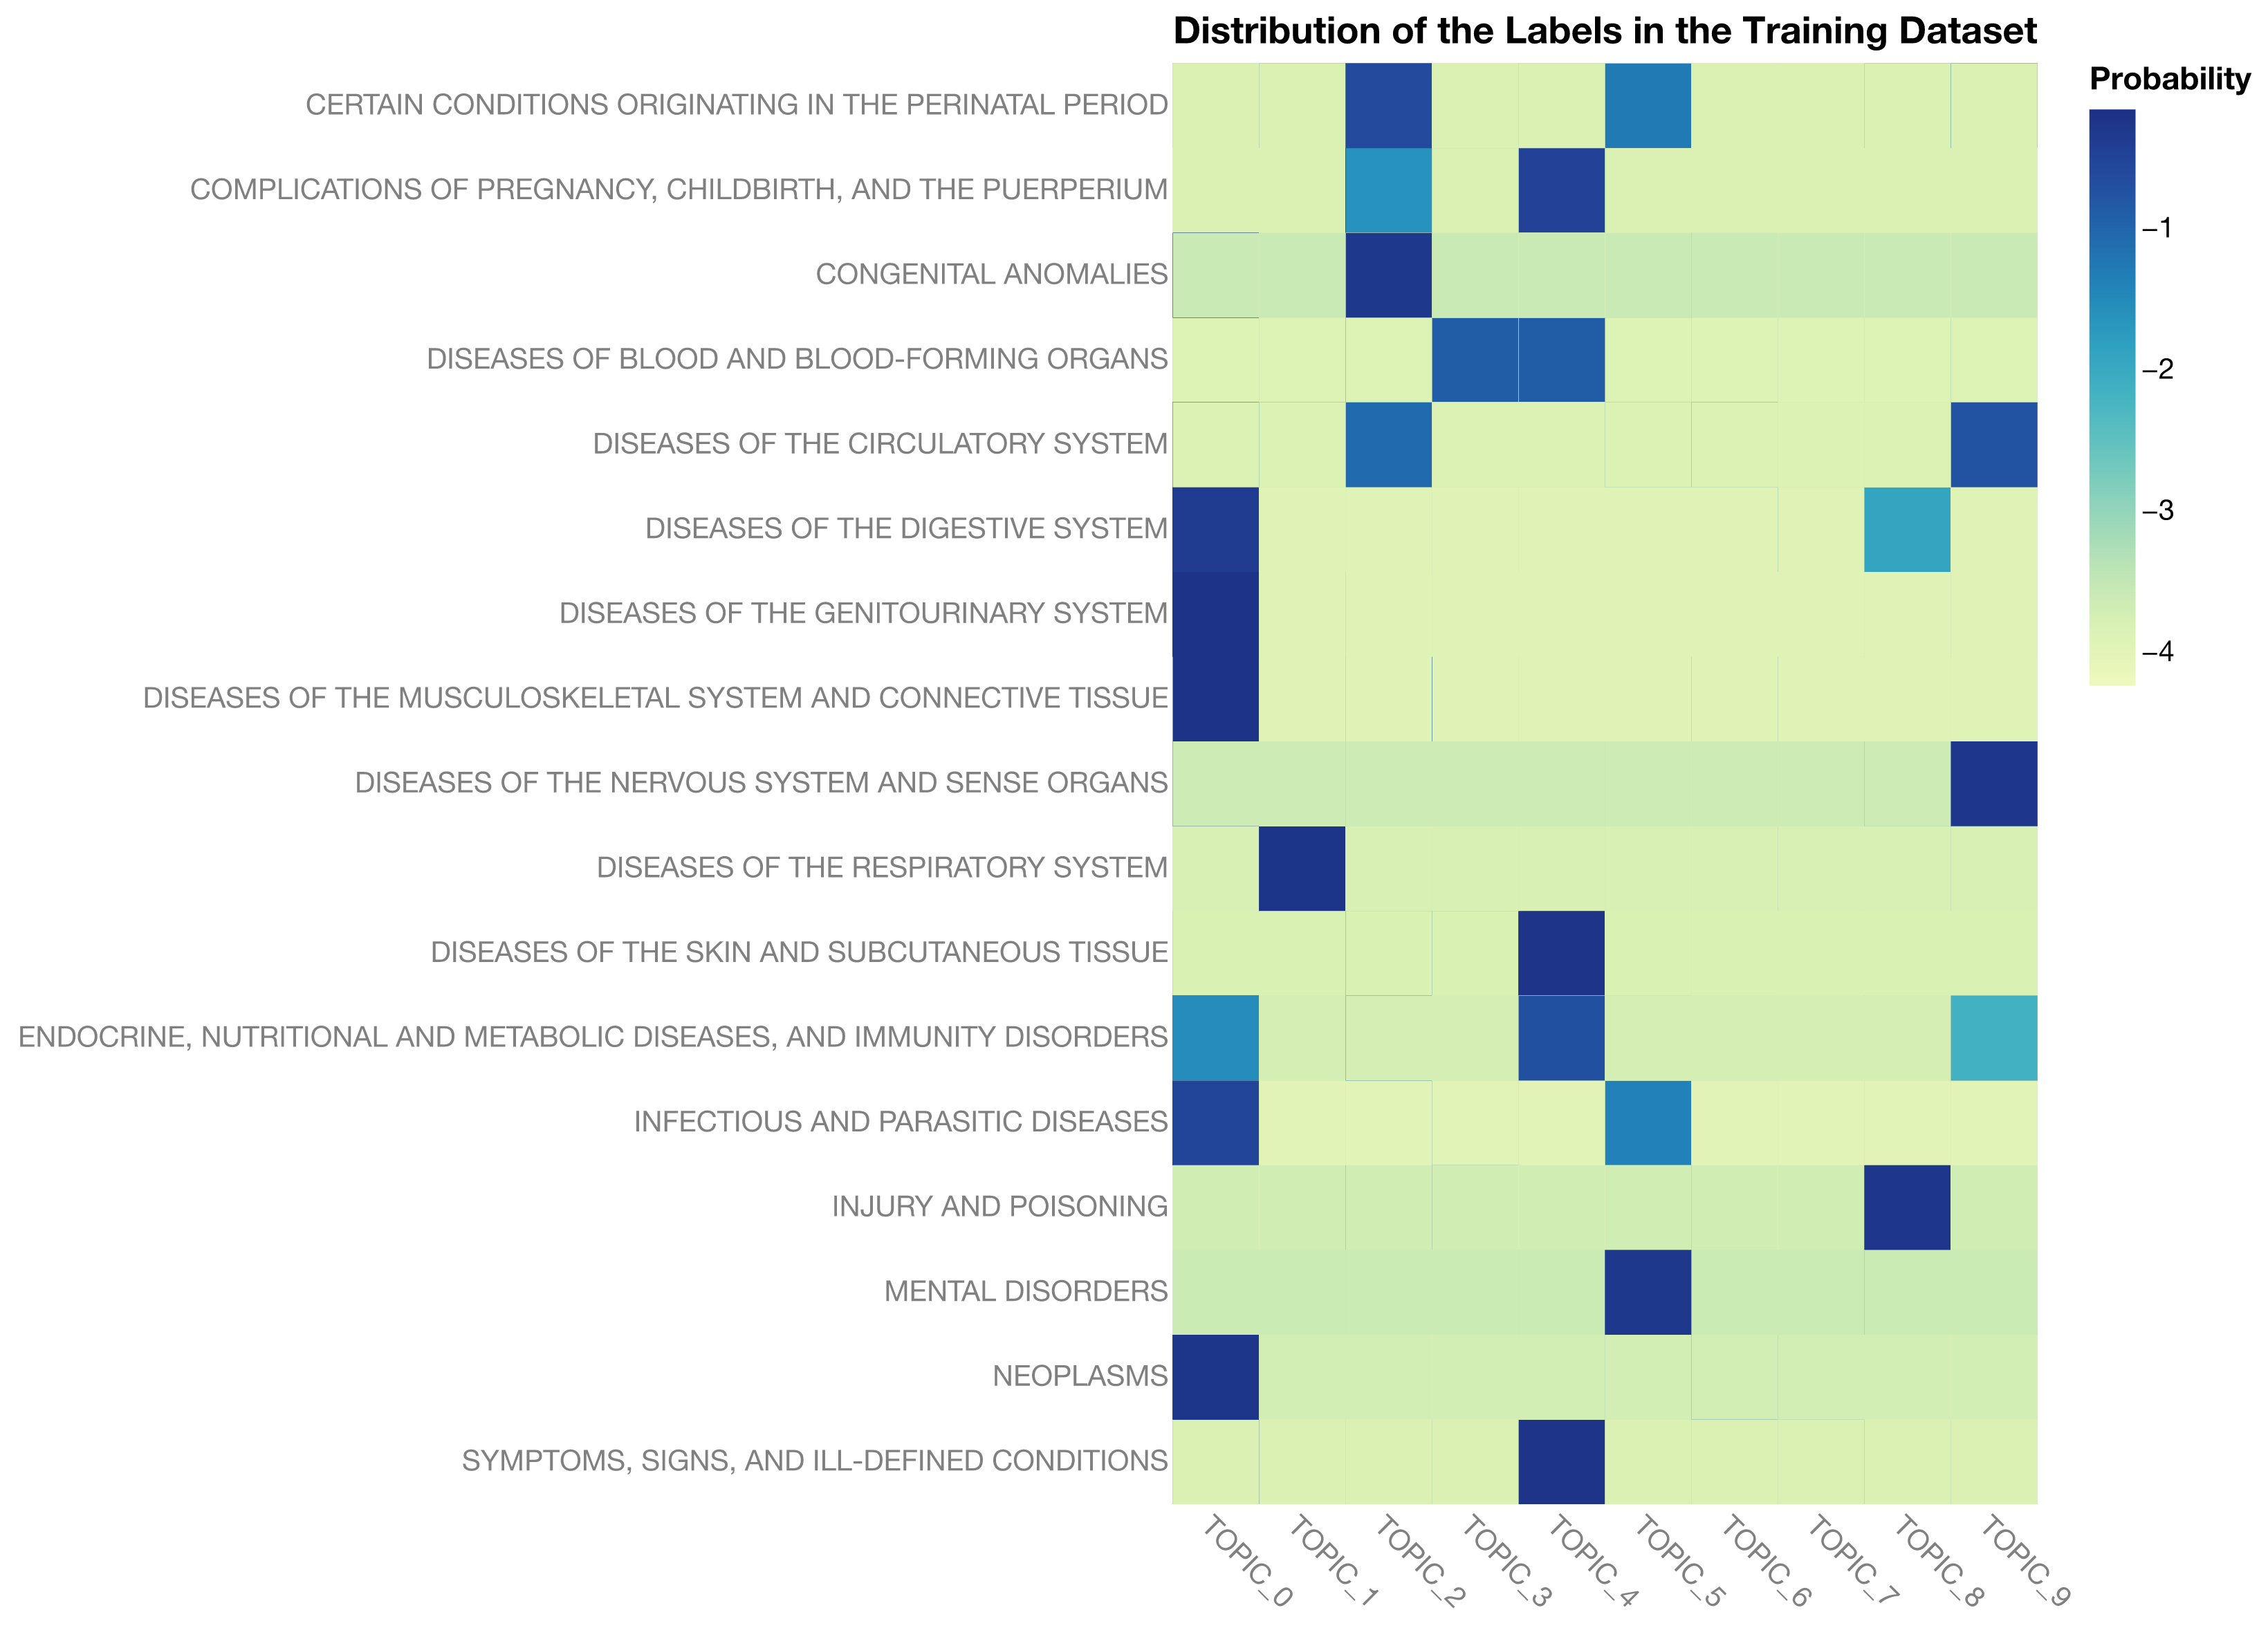

In [61]:
from IPython.display import Image
display(Image(filename=os.path.join(figure_path, 'topic_distribution_heatmap.png')))

In [62]:
# Check the distribution and percentage of the labels in the training dataset
y_train.value_counts(normalize=True)

# Plot the distribution and percentage of true labels
chart(
    df=y_train.value_counts(normalize=True).reset_index(),
    x='DIAG1_CAT:N',
    y='proportion:Q',
    title='Distribution of the Labels in the Training Dataset',
).mark_bar().configure_axisX(labelAngle=45, labelLimit=300, title=None).configure_axisY(title=None)

alt.Chart(...)

##### 5.2.1.2 - Account for the imbalance in the labels

In [63]:
from imblearn.under_sampling import RandomUnderSampler

In [64]:
# Random Undersampling
def random_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

    return X_train_resampled, y_train_resampled


#X_train, y_train = random_undersampling(X_train, y_train)

##### 5.2.1.3 - Confirm the distribution and percentage of the labels in the training dataset

In [65]:
# Check the distribution and percentage of the labels in the training dataset
y_train.value_counts(normalize=True)

# Plot the distribution and percentage of true labels
chart(
    df=y_train.value_counts(normalize=True).reset_index(),
    x='DIAG1_CAT:N',
    y='proportion:Q',
    title='Distribution of the Labels in the Training Dataset',
).mark_bar().configure_axisX(labelAngle=45, labelLimit=300, title=None).configure_axisY(title=None)

alt.Chart(...)

#### 5.2.2 - Model training

In [66]:
# Train the model
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

clf_features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[clf_features].isna().sum().where(lambda x: x > 0).dropna()}')
print()

# Define the model
n_neighbors = 5
clf_pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    #imputer='knn',
    n_neighbors=n_neighbors,
    #pca=True,
    #ovr=True
)

clf_model_name = clf_pipeline.named_steps['classifier'].__class__.__name__
if 'one' in clf_model_name.lower():
    clf_model_name = f'OneVsRest {type(clf_pipeline.esitmator).__name__}'
print(f'Classifier: {clf_model_name}')
print()

# Drop rows with missing values in the quantitative features in both X_train and y_train
#non_missing_mask = X_train[clf_features].notna().all(axis=1)

#print(f'Number of available samples: {non_missing_mask.sum()}')
#X_train = X_train.loc[non_missing_mask]
#y_train = y_train.loc[non_missing_mask]

print(f'Shape of X_train: {X_train[clf_features].shape}')
print(f'Features to be fit: \n{X_train[clf_features].columns}')
print()

clf_pipeline.fit(X_train[clf_features], y_train)

Missing Values in X_train: 
PASTVIS    15702.0
HTIN       44208.0
WTLB       27592.0
BMI        48130.0
TEMPF      41616.0
BPSYS      31244.0
BPDIAS     31342.0
dtype: float64

Classifier: RandomForestClassifier

Shape of X_train: (78946, 45)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'TOPIC_0',
       'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6',
       'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', 'passthrough',
                                                  ['SEX', 'USETOBAC',
                                                   'ARTHRTIS', 'ASTHMA',
                                                   'CANCER', 'CEBVD', 'CHF',
                                                   'CRF', 'COPD', 'DEPRN',
                                                   'DIABETES', 'HYPLIPID',
                                                   'HTN', 'IHD', 'OBESITY',
                                                   'OSTPRSIS']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['INJDET', 'MAJOR', 'RFV1',
                                                   'RFV2', 'RFV3', 'RFV1_MOD1',
                                                   'RFV2_MOD1', 'RFV3_MOD1',
                                                   'RFV1_MOD2', 'RFV2_MOD2',
                                                   'RFV3_MOD2'])])),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', n_estimators=1000,
                                        n_jobs=-1, random_state=42))])

##### 5.2.2.1 - Visualize the feature importances of the top 20 features

In [67]:
importances = clf_pipeline.named_steps['classifier'].feature_importances_
feature_names = clf_pipeline[:-1].get_feature_names_out(clf_features)

indices = np.argsort(importances)[::-1]
feature_names = [feature_names[i] for i in indices]

# Plot the feature importances
top_n = 20

chart(
    df=pd.DataFrame({'Feature': feature_names, 'Importance': importances[indices]}).head(top_n),
    x=alt.X('Feature:N', sort='-y'),
    y='Importance:Q',
    title=f'Top {top_n} Feature Importances',
).mark_bar().configure_axisX(labelAngle=45, labelLimit=300, title=None).configure_axisY(title=None)

alt.Chart(...)

#### 5.2.3 - Load and prepare the test dataset

In [68]:
# Load the test dataset
test_df = pd.read_parquet(os.path.join(input_path, 'test.parquet'))

test_df = build_features.build_features(test_df, rfv_df, icd9cm_df, category=icd9cm_category)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [69]:
# Drop the rows from with NA in 'DIAG1_CAT'
non_missing_mask = test_df['DIAG1_CAT'].notna()
print(f'Number of available dependent samples: {non_missing_mask.sum()}')
print()

# Define the X_test and y_test
X_test = test_df.loc[non_missing_mask, X_features]
print(f'X Shape: {X_test.shape}')

y_test = test_df.loc[non_missing_mask, 'DIAG1_CAT']
print(f'y with {icd9cm_category} Shape: {y_test.shape}')

# Combine and preprocess textual features
X_test['TEXT'] = X_test.apply(lambda x: build_features.combine_textual(x, textual_features), axis=1)

# Add in word embeddings using BERT and pre-trained BiomedBERT model 
#X_train = build_features.generate_embeddings(X_train)

# Add in topic feature (topic probabilities) using LDA
X_test, vectorizer, tf, lda, topic_features = build_features.generate_topic_features(
    X_test, n_topics=10, n_top_words=10, transform='log'
)

Number of available dependent samples: 26719

X Shape: (26719, 47)
y with CATEGORY_1 Shape: (26719,)
Topic 0:
symptom, disorder, medication, mental, psychological, depression, referable, kind, chronic, unspecified

Topic 1:
symptom, skin, referable, nervous, hair, nail, sense, exclude, organ, headache

Topic 2:
symptom, musculoskeletal, ache, pain, soreness, counseling, discomfort, referable, medical, hypertension

Topic 3:
symptom, respiratory, referable, new, child_or_teenager, cough, fever, normal_temperature, digestive, throat

Topic 4:
specific, therapeutic, procedure, eye, ears, therapy, treatment, symptom, type, chronic

Topic 5:
disease, test, result, hypertension, endocrine, nutritional, chronic, circulatory, immunity, metabolic

Topic 6:
symptom, genitourinary, referable, digestive, abdominal, cramp, pain, spasm, disease, new

Topic 7:
injury, effect, adverse, poison, location, type, unknown_intent, unintentional, adverse_effect, unspecified

Topic 8:
preventive, examination,

In [70]:
# Drop rows with missing values in the quantitative features in both X_train and y_train
#non_missing_mask = X_test[clf_features].notna().all(axis=1)

#print(f'Number of available samples: {non_missing_mask.sum()}')
#X_test = X_test.loc[non_missing_mask]
#y_test = y_test.loc[non_missing_mask]

In [71]:
# Check the distribution and percentage of true labels
y_test.value_counts(normalize=True)

# Plot the distribution and percentage of true labels
chart(
    df=y_test.value_counts(normalize=True).reset_index(),
    x='DIAG1_CAT:N',
    y='proportion:Q',
    title='Distribution of True Labels',
).mark_bar().configure_axisX(labelAngle=45)

alt.Chart(...)

#### 5.2.4 - Prediction and Metrics

In [72]:
y_pred = clf_pipeline.predict(X_test)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [73]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_pred_encoded = le.transform(y_pred)

n_classes = len(le.classes_)
y_test_binarized = label_binarize(y_test_encoded, classes=range(n_classes))
y_pred_binarized = label_binarize(y_pred_encoded, classes=range(n_classes))

lrap = label_ranking_average_precision_score(y_test_binarized, y_pred_binarized)
print(f'Label Ranking Average Precision Score: {lrap}')

Label Ranking Average Precision Score: 0.6091787514064081


In [74]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Weighted Prediction F1 Score: {f1}')

print(classification_report(y_test[y_test.notna()], y_pred[y_test.notna()]))

Prediction Accuracy: 0.584752423369138
Weighted Prediction F1 Score: 0.5716403262495825
                                                                       precision    recall  f1-score   support

               CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.38      0.31      0.34        64
           COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.82      0.76      0.79       809
                                                 CONGENITAL ANOMALIES       0.58      0.21      0.31       347
                           DISEASES OF BLOOD AND BLOOD-FORMING ORGANS       0.70      0.22      0.34       356
                                   DISEASES OF THE CIRCULATORY SYSTEM       0.47      0.55      0.51      2146
                                     DISEASES OF THE DIGESTIVE SYSTEM       0.59      0.34      0.43      1147
                                 DISEASES OF THE GENITOURINARY SYSTEM       0.53      0.57      0.55      1455
         DISEASES OF TH

#### 5.2.5 - Confusion matrix

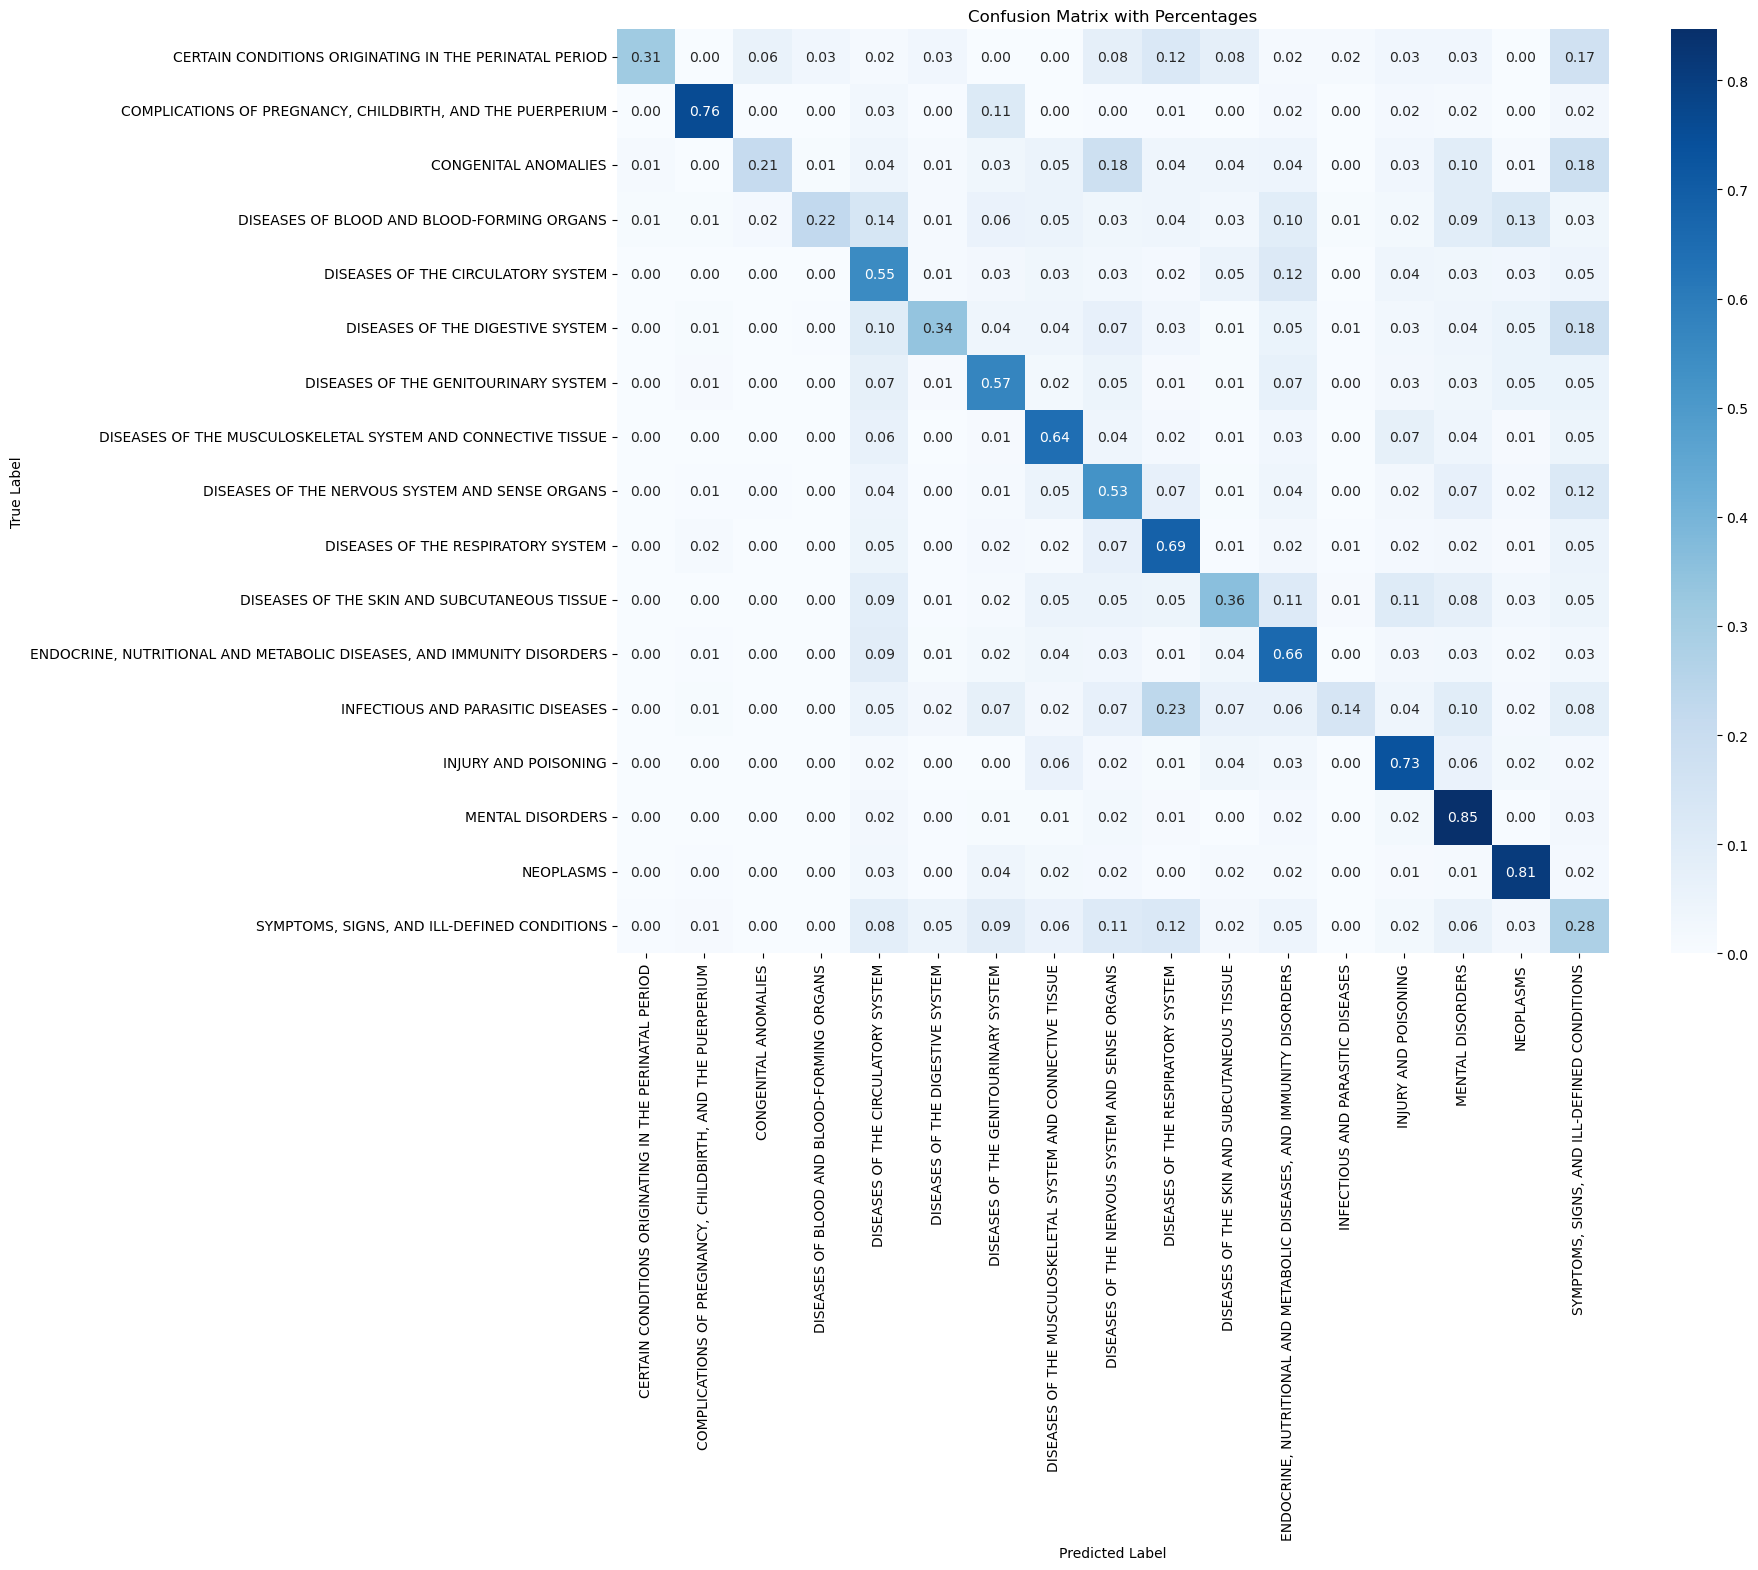

In [75]:
# Plot the confusion matrix with percentages
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 12))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=clf_pipeline.classes_, yticklabels=clf_pipeline.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()